In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using BenchmarkTools
import KernelFunctions: PeriodicKernel, SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature


## Prepare data 

In [3]:
function generate_data(n, f_gp, c_gp, σ_y)
    y=[]
    obs = []
    for i=1:n
        temp = c_gp[i] * exp(f_gp[i]) 
        push!(y,temp)
        push!(obs, temp + σ_y*randn())
    end
    return y , obs
end

generate_data (generic function with 1 method)

## Specify model

In [ ]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output

In [ ]:
### rule for y 
##TODO: this rule needs to be investigated for speed vs. accuracy 
@rule MyExponential(:y, Marginalisation) (m_x::GaussianProcess, meta::ProcessMeta) = begin
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
    dist = LogNormal(m_gp[index],cov_gp[index,index]+1e-12)
    return dist
end

### rule for x
@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x)) 
    return ContinuousUnivariateLogPdf(log_pdf)
end


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    dist = LogNormal(mean(m_x), var(m_x))
    return dist
end
    
@rule MyExponential(:x, Marginalisation) (m_y::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    μ_y, var_y =  mean_var(m_y)
    log_pdf = (x) -> logpdf(NormalMeanVariance(μ_y, var_y),exp(x)) 
    return ContinuousUnivariateLogPdf(log_pdf)
end

In [ ]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    return NormalMeanVariance(m,v)
end


function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,1000)
    weights = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
    weight = weights / sum(weights)
    m = sum(weight .* log.(sample_left))
    v = sum(weight .* (log.(sample_left) .- m).^2)
    return LogNormal(m,v)
end

@rule NormalMeanVariance(:v, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanVariance(:v, Marginalisation) (q_out=d_out, q_μ=q_μ, ) 
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::PointMass, m_v::InverseGamma, ) = begin 
    return  @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ=q_μ, q_v=m_v, )
end

@rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out=d_out, q_μ =q_μ , )
end

@rule NormalMeanPrecision(:out, Marginalisation) (q_μ::PointMass, m_τ::Gamma, ) = begin 
    return  @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=q_μ, q_τ=m_τ, )
end

@rule GaussianProcess(:params, Marginalisation) (m_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any, q_params::UnivariateGaussianDistributionsFamily, meta::Unscented) = begin 
    return @call_rule GaussianProcess(:params, Marginalisation) (q_out=m_out, q_meanfunc=q_meanfunc, q_kernelfunc=q_kernelfunc, q_params=q_params, meta=meta)
end

@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    return @call_rule typeof(*)(:A, Marginalisation) (m_out=m_out,m_in=m_in,meta=TinyCorrection())
end




In [ ]:
AmplitudePrior_mean = (x) -> 0.0
CarrierPrior_mean = (x) -> 0.0

In [ ]:
#Test with GP with fixed hyperparameters
@model function modulation(n, precision,amplitude_kernel,amplitude_mean, carrier_kernel, carrier_mean,train,test, gpstrategy1,gpstrategy2)
    amplitude   = randomprocess(test, train, gpstrategy1)
    carrier     = randomprocess(test, train, gpstrategy2)
    observation = datavar(Float64,n)
    g = randomvar(n)
    w = randomvar(n)

    amplitude ~ GaussianProcess(amplitude_mean, amplitude_kernel, log(0.05)) 
    carrier   ~ GaussianProcess(carrier_mean, carrier_kernel, log(0.05)) 
    for i=1:n 
        g[i] ~ MyExponential(amplitude) where {meta = ProcessMeta(i)}
        w[i] ~ *(carrier, g[i]) where {meta = ProcessMeta(i)}
        observation[i] ~ NormalMeanPrecision(w[i],precision)
    end
end

In [ ]:
# Random.seed!(123456)
σ_y = 0.001 ## we assume low noise for now

N = 500; #data length
n = 500; #lenght of the axis of gp 
θcarrier   = 0.05
θamplitude = 0.05
mean_amplitude = (x) -> 0.3*sin(2pi*x*4) + 0.3*exp(-x^2);
mean_carrier   = (x) -> cos(2pi*x*10)
kernel_carrier(θ)     =  with_lengthscale(SqExponentialKernel(),θ)
kernel_amplitude(θ)   =  with_lengthscale(SqExponentialKernel(),θ) #+ with_lengthscale(PeriodicKernel(),3.0)
tmin,tmax = 0., 5.0
time_range = collect(range(tmin, tmax; length=n));
Cov_amplitude = kernelmatrix(kernel_amplitude(θamplitude),time_range,time_range) + 1e-7*I;
Cov_carrier   = kernelmatrix(kernel_carrier(θcarrier),time_range,time_range) + 1e-7I;
gp_amplitude  = MvNormal(mean_amplitude.(time_range), Cov_amplitude)
gp_carrier    = MvNormal(mean_carrier.(time_range), Cov_carrier)
amplitude_gt = rand(StableRNG(14),gp_amplitude)
carrier_gt   = rand(StableRNG(14), gp_carrier)
#Observe data 
pos = sort(randperm(StableRNG(1),n)[1:N]); # position where we observe data
time_train = time_range[pos]


#Generate data 
y_true_state,y_data = generate_data(n,amplitude_gt,carrier_gt,σ_y);

cov_strategy1 = CovarianceMatrixStrategy(RandomFourierFeature(100))
cov_strategy2 = CovarianceMatrixStrategy(RandomFourierFeature(100))
# cov_strategy1 = CovarianceMatrixStrategy(FullCovarianceStrategy())
# cov_strategy2 = CovarianceMatrixStrategy(FullCovarianceStrategy())
# cov_strategy = CovarianceMatrixStrategy(SoR(50))

In [ ]:
iresult = inference(
    model = modulation(length(y_data),1/σ_y^2, kernel_amplitude, mean_amplitude, kernel_carrier, mean_carrier , time_train,time_range, cov_strategy1,cov_strategy2),
    initmessages = (
                    # amplitude  = GaussianProcess(mean_amplitude,kernel_amplitude(0.5),MvNormalMeanCovariance(mean_amplitude.(time_range),Cov_amplitude),time_range,time_train,Float64[], cov_strategy1),
                    carrier  = GaussianProcess(mean_carrier,kernel_carrier(0.05),MvNormalMeanCovariance(mean_carrier.(time_range),Cov_carrier),time_range,time_train,Float64[], cov_strategy2),
                    ),
    returnvars = (amplitude=KeepEach(),carrier=KeepEach(), ),
    data  = (observation = y_data,),
    iterations = 5,
    showprogress = false,
    free_energy = false,
)

In [ ]:
mamplitude = mean(iresult.posteriors[:amplitude][end].data.finitemarginal)
vamplitude = var(iresult.posteriors[:amplitude][end].data.finitemarginal)
expvgp = exp.( mamplitude .+ vamplitude)
expmgp = exp.(mamplitude);

mcarriers = mean(iresult.posteriors[:carrier][end].data.finitemarginal)
vcarriers = var(iresult.posteriors[:carrier][end].data.finitemarginal);

In [ ]:
from = 1
to   = N
skip = 1

plot(time_range, mcarriers[from:skip:to],ribbon=sqrt.((vcarriers[from:skip:to])),label="GP carrier estimate",linewidth=3.0, fillalpha=0.2, color="green", size=(700,400))
plot!(time_range, carrier_gt[from:skip:to],linewidth=3.0, color="blue", label="GP carrier true",alpha=0.6,ls=:dash)

In [ ]:

plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green, size=(700,400))
plot!(time_range,exp.(amplitude_gt), label="modulator GP-true",linewidth=3.0,color=:blue, ls=:dash)
# scatter!(time_range,y_data, label="observation",color=:black,alpha=0.9,ms=3)

## Test with real data 

In [ ]:
using WAV, MAT

In [ ]:
datapath = "/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/data/"
file = matopen(datapath*"filter_outputs.mat")
FilteredOutput = read(file, "data")

X, fs = wavread(datapath*"data_05-Bubblingstream.wav");
fs = Float64(fs);

In [ ]:
data = FilteredOutput[:,2];
NumberOfSamples = length(data);
signal_time = 1/fs * (NumberOfSamples-1);
signaltime_range = collect(0.:1/fs:signal_time); 
data = data / sqrt(var(data));

# #Let's use 1 second of the signal 
NumberOfTruncatedSignalSamples = Int(round(fs+1))
y_data = data[1:NumberOfTruncatedSignalSamples] 
t_data = collect(0.:1/fs:(NumberOfTruncatedSignalSamples-1) / fs);

In [ ]:
from = 1 
to = length(y_data)
skip = 1

plot(t_data,y_data,size = (800,200))

In [ ]:
# Random.seed!(123456)
σ_y = 0.001 ## we assume low noise for now

θcarrier   = 0.0001
θamplitude = 0.015
mean_amplitude = (x) -> 0.;
mean_carrier   = (x) -> 0.;
kernel_carrier(θ)     =  with_lengthscale(SqExponentialKernel(),θ)
kernel_amplitude(θ)   =  with_lengthscale(SqExponentialKernel(),θ) #+ with_lengthscale(PeriodicKernel(),3.0)
Cov_amplitude = kernelmatrix(kernel_amplitude(θamplitude),t_data,t_data) + 1e-7*I;
Cov_carrier   = kernelmatrix(kernel_carrier(θcarrier),t_data,t_data) + 1e-7I;

cov_strategy1 = CovarianceMatrixStrategy(RandomFourierFeature(500))
cov_strategy2 = CovarianceMatrixStrategy(RandomFourierFeature(500))

In [91]:
#Test with GP with fixed hyperparameters
@model function modulation(n, precision,θamplitude,θcarrier,amplitude_kernel,amplitude_mean, carrier_kernel, carrier_mean,train,test, gpstrategy1,gpstrategy2)
    amplitude   = randomprocess(test, train, gpstrategy1)
    carrier     = randomprocess(test, train, gpstrategy2)
    observation = datavar(Float64,n)
    g = randomvar(n)
    w = randomvar(n)

    amplitude ~ GaussianProcess(amplitude_mean, amplitude_kernel, log(θamplitude)) #where {pipeline = RequireMarginal(params)}
    carrier   ~ GaussianProcess(carrier_mean, carrier_kernel, log(θcarrier)) #where {pipeline = RequireMarginal(params)}
    for i=1:n 
        g[i] ~ MyExponential(amplitude) where {meta = ProcessMeta(i)}
        w[i] ~ *(carrier, g[i]) where {meta = ProcessMeta(i)}
        observation[i] ~ NormalMeanPrecision(w[i],precision)
    end
end

In [98]:
iresult = inference(
    model = modulation(length(y_data),1/σ_y^2, θamplitude,θcarrier, kernel_amplitude, mean_amplitude, kernel_carrier, mean_carrier , t_data,t_data, cov_strategy1,cov_strategy2),
    initmessages = (
                    carrier  = GaussianProcess(mean_carrier,kernel_carrier(θcarrier),MvNormalMeanCovariance(mean_carrier.(t_data),Cov_carrier),t_data,t_data,Float64[], cov_strategy2),
                    ),
    returnvars = (amplitude=KeepEach(), carrier=KeepEach(),),
    data  = (observation = y_data,),
    iterations = 2,
    showprogress = false,
    free_energy = false,
)

Inference results:
  Posteriors       | available for (amplitude, carrier)


In [99]:
mamplitude = mean(iresult.posteriors[:amplitude][end].data.finitemarginal)
vamplitude = var(iresult.posteriors[:amplitude][end].data.finitemarginal);
expvgp = exp.( mamplitude .+ vamplitude);
expmgp = exp.(mamplitude);

mcarriers = mean(iresult.posteriors[:carrier][end].data.finitemarginal)
vcarriers = var(iresult.posteriors[:carrier][end].data.finitemarginal);
;

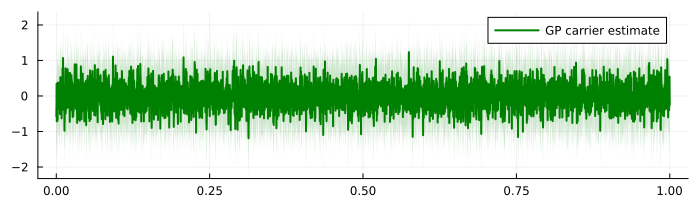

In [104]:
plot(t_data[from:skip:to], mcarriers[from:skip:to],ribbon=sqrt.((vcarriers[from:skip:to])),label="GP carrier estimate",linewidth=2.0, fillalpha=0.2, color="green", size=(700,200))

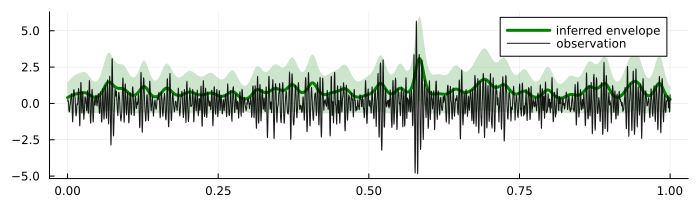

In [105]:
from = 1
to = length(y_data)
skip = 1
plot(t_data[from:skip:to],expmgp[from:skip:to],ribbon=sqrt.(expvgp),linewidth=3.0,label="inferred envelope",fillalpha=0.2,color=:green, size=(700,200))
plot!(t_data[from:skip:to],y_data[from:skip:to], label="observation",color=:black,alpha=0.9,ms=3)

## Benchmark

In [71]:
# cov_strategy1 = CovarianceMatrixStrategy(FullCovarianceStrategy())
# cov_strategy2 = CovarianceMatrixStrategy(FullCovarianceStrategy())

cov_strategy1 = CovarianceMatrixStrategy(RandomFourierFeature(100))
cov_strategy2 = CovarianceMatrixStrategy(RandomFourierFeature(100))

CovarianceMatrixStrategy{RandomFourierFeature{Vector{Int64}, Nothing}}(RandomFourierFeature{Vector{Int64}, Nothing}(Int64[], nothing, 100, Float64[], [1.0;;], [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [72]:
@benchmark iresult = inference(
    model = modulation(length(y_data),1/σ_y^2,kernel_amplitude ,mean_amplitude, kernel_carrier,mean_carrier, time_train,time_range, cov_strategy1,cov_strategy2),
    initmessages = (
#                     amplitude  = GaussianProcess(mean_amplitude,kernel_amplitude(θamplitude),MvNormalMeanCovariance(mean_amplitude.(time_range),Cov_amplitude),time_range,time_train,Float64[], cov_strategy1),
                    carrier  = GaussianProcess(mean_carrier,kernel_carrier(0.05),MvNormalMeanCovariance(mean_carrier.(time_range),Cov_carrier),time_range,time_train,Float64[], cov_strategy2),
                    ),
    returnvars = (amplitude=KeepEach(),carrier=KeepEach(),),
    data  = (observation = $y_data,),
    iterations = 3,
    showprogress = false,
    free_energy = false,
)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 17.590 s (0.71% GC) to evaluate,
 with a memory estimate of 2.05 GiB, over 2570110 allocations.

In [ ]:
#Full covariance (2iters, 2000samples)
BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 19.227 s (0.78% GC) to evaluate,
 with a memory estimate of 2.53 GiB, over 2546266 allocations.

In [ ]:
#RFF 50 samples (2iters, 2000 samples)
BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 17.508 s (0.71% GC) to evaluate,
 with a memory estimate of 2.02 GiB, over 2570110 allocations.

In [ ]:
# RFF with 100 samples (5iters)
BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 17.590 s (0.71% GC) to evaluate,
 with a memory estimate of 2.05 GiB, over 2570110 allocations.

In [ ]:
## Full covariance
BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.033 s (1.11% GC) to evaluate,
 with a memory estimate of 1.13 GiB, over 1496174 allocations.

In [ ]:
#before optimizing (RFF)
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.191 s …   1.256 s  ┊ GC (min … max): 0.00% … 2.66%
 Time  (median):     1.213 s              ┊ GC (median):    1.49%
 Time  (mean ± σ):   1.219 s ± 24.648 ms  ┊ GC (mean ± σ):  1.26% ± 1.21%

  █             █    █            █                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.19 s         Histogram: frequency by time        1.26 s <

 Memory estimate: 155.14 MiB, allocs estimate: 299742.

In [ ]:
#1st trial
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.194 s …   1.223 s  ┊ GC (min … max): 0.00% … 1.42%
 Time  (median):     1.202 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.208 s ± 12.741 ms  ┊ GC (mean ± σ):  0.63% ± 0.85%

  ▁             █                                    ▁    ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  1.19 s         Histogram: frequency by time        1.22 s <

 Memory estimate: 147.81 MiB, allocs estimate: 299728.

In [ ]:
#2nd trial 
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.196 s …   1.230 s  ┊ GC (min … max): 0.00% … 1.65%
 Time  (median):     1.217 s              ┊ GC (median):    1.36%
 Time  (mean ± σ):   1.214 s ± 13.465 ms  ┊ GC (mean ± σ):  0.91% ± 0.83%

  █             █                   █     █               █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.2 s          Histogram: frequency by time        1.23 s <

 Memory estimate: 147.81 MiB, allocs estimate: 299740.

In [ ]:
#3rd trial 
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.190 s …   1.214 s  ┊ GC (min … max): 0.00% … 1.43%
 Time  (median):     1.198 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.202 s ± 10.430 ms  ┊ GC (mean ± σ):  0.61% ± 0.83%

  █               █  █                               █    █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  1.19 s         Histogram: frequency by time        1.21 s <

 Memory estimate: 147.81 MiB, allocs estimate: 299740.

In [ ]:
#4th trial 
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.193 s …   1.224 s  ┊ GC (min … max): 0.00% … 1.36%
 Time  (median):     1.222 s              ┊ GC (median):    1.36%
 Time  (mean ± σ):   1.214 s ± 13.662 ms  ┊ GC (mean ± σ):  0.88% ± 0.80%

  █                      █                            █  ██  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁██ ▁
  1.19 s         Histogram: frequency by time        1.22 s <

 Memory estimate: 147.81 MiB, allocs estimate: 299740.

 BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.184 s …   1.210 s  ┊ GC (min … max): 0.00% … 1.53%
 Time  (median):     1.195 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.198 s ± 10.950 ms  ┊ GC (mean ± σ):  0.59% ± 0.80%

  █                   █  █                           █    █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  1.18 s         Histogram: frequency by time        1.21 s <

 Memory estimate: 147.81 MiB, allocs estimate: 299740.

In [ ]:
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.182 s …   1.211 s  ┊ GC (min … max): 0.00% … 1.69%
 Time  (median):     1.194 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.197 s ± 11.390 ms  ┊ GC (mean ± σ):  0.62% ± 0.85%

  █                   █  █                         █      █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█ ▁
  1.18 s         Histogram: frequency by time        1.21 s <

 Memory estimate: 147.81 MiB, allocs estimate: 299740.

In [ ]:

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.174 s …   1.200 s  ┊ GC (min … max): 0.00% … 1.54%
 Time  (median):     1.177 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.184 s ± 11.581 ms  ┊ GC (mean ± σ):  0.62% ± 0.84%

  █     █ █                                  █            █  
  █▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.17 s         Histogram: frequency by time         1.2 s <

 Memory estimate: 132.44 MiB, allocs estimate: 299714.

In [ ]:
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.169 s …   1.203 s  ┊ GC (min … max): 0.00% … 1.56%
 Time  (median):     1.175 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.184 s ± 15.307 ms  ┊ GC (mean ± σ):  0.63% ± 0.86%

  █        ██                                   █         █  
  █▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█ ▁
  1.17 s         Histogram: frequency by time         1.2 s <

 Memory estimate: 132.44 MiB, allocs estimate: 299714.

In [ ]:
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.166 s …   1.245 s  ┊ GC (min … max): 0.00% … 1.61%
 Time  (median):     1.181 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.198 s ± 32.706 ms  ┊ GC (mean ± σ):  0.64% ± 0.85%

  █       █ █                           █                 █  
  █▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.17 s         Histogram: frequency by time        1.24 s <

 Memory estimate: 128.63 MiB, allocs estimate: 298104.

In [ ]:
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.178 s …   1.294 s  ┊ GC (min … max): 0.00% … 1.45%
 Time  (median):     1.198 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.211 s ± 47.572 ms  ┊ GC (mean ± σ):  0.65% ± 0.87%

  █ █      █ █                                            █  
  █▁█▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.18 s         Histogram: frequency by time        1.29 s <

 Memory estimate: 129.99 MiB, allocs estimate: 299696.

In [ ]:
BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.161 s …   1.205 s  ┊ GC (min … max): 0.00% … 1.43%
 Time  (median):     1.171 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.179 s ± 17.918 ms  ┊ GC (mean ± σ):  0.59% ± 0.79%

  █          ██                       █                   █  
  █▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.16 s         Histogram: frequency by time        1.21 s <

 Memory estimate: 117.42 MiB, allocs estimate: 299684.